## Summary

This notebook demonstrates how to build advanced chatbots using LangGraph and LangChain, integrating OpenAI's GPT models and external tools. It covers:

- **Basic Chatbot Construction:** Using LangGraph's StateGraph to create a simple conversational agent.
- **Tool Integration:** Enhancing the chatbot with external tools like TavilySearch and custom functions (e.g., multiplication).
- **Multi-step Reasoning (ReAct):** Implementing recursive flows to handle complex, multi-part user queries.
- **Memory Management:** Adding conversational memory to enable context-aware responses and follow-up questions.
- **Streaming Responses:** Utilizing LangChain's streaming capabilities for real-time interaction.

The notebook provides practical code examples for each concept, making it a comprehensive guide for building intelligent, tool-augmented chatbots.

**Reference:**  
Inspired by Krish Naik's YouTube video: [LangGraph - Build Advanced Chatbots with OpenAI, LangChain & Tools](https://www.youtube.com/watch?v=dIb-DujRNEo)


### 1.1 Building a basic chatbot with Langgraph (Graph API)

In [108]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages # add_messages is a reducer
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.chat_models import init_chat_model

from langchain_tavily import TavilySearch
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

load_dotenv()
memory = MemorySaver()

In [109]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages`function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list, add_messages]

In [110]:
llm = ChatOpenAI(model="gpt-4o")

In [111]:
# Node functionality
def chatbot(state:State):
    return {'messages': [llm.invoke(state['messages'])]}

In [112]:
graph_builder = StateGraph(State)

# Create a node
graph_builder.add_node("LLMChatbot", chatbot)

# Establish edges
graph_builder.add_edge(START, "LLMChatbot")
graph_builder.add_edge("LLMChatbot", END)

# Complie graph
graph = graph_builder.compile()

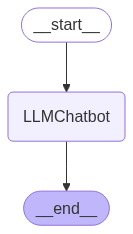

In [113]:
graph

In [114]:
response = graph.invoke({"messages":"Hi"})

In [115]:
response

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='15c38bc1-bab6-4480-9764-52180d777409'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-C64GG1EiqqYSjSRWjUkubaqL2k5Ih', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--bbaa0189-e568-479a-af06-6c4810a09d6e-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [116]:
response['messages'][-1].content

'Hello! How can I assist you today?'

In [117]:
for event in graph.stream({"messages": "Hi, how are you?"}):
    for value in event.values():
        print(value['messages'][-1].content)


Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


In [118]:
for event in graph.stream({"messages": "Can you give me some recent AI related news along with the date the news was published?"}):
    for value in event.values():
        print(value['messages'][-1].content)


Sure! Here are a few recent AI-related news items, but please note that this information is only accurate as of October 2023:

1. **Google’s Gemini AI Challenges OpenAI's GPT**  
   *Published: October 2023*  
   Google's AI division announced the launch of Gemini, a new AI model designed to compete directly with OpenAI's GPT series. With enhanced language understanding and generation capabilities, Gemini aims to power a range of Google services and products.

2. **Meta Unveils SeamlessM4T, A New Multimodal AI Model**  
   *Published: October 2023*  
   Meta Platforms introduced SeamlessM4T, an advanced AI model capable of translating and transcribing multiple languages and dialects in real-time. This innovation aims to improve global communication by breaking down language barriers.

3. **NVIDIA Expands AI GPU Offerings**  
   *Published: September 2023*  
   NVIDIA announced an expansion of its line of GPUs specifically optimized for AI workloads, emphasizing improvements in energy e

### 1.2 Chatbot with tools

In [119]:
searchtool = TavilySearch(max_results=2)
searchtool.invoke("What is langgraph?")

{'query': 'What is langgraph?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.ibm.com/think/topics/langgraph',
   'title': 'What is LangGraph? - IBM',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. Nodes: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making by modeling 

In [120]:
def multiply(a:int, b:int)->int:
    """
    Multiple a with b.

    a (int): First integer
    b (int): Second integer

    Returns:
        int: output integer product
    """
    return int(a*b)

In [121]:
tools=[searchtool, multiply]
llm_with_tools=llm.bind_tools(tools)

In [122]:
def tools_calling_llm(state:State):
    return {"messages": llm_with_tools.invoke(state['messages'])}

### New StateGraph
builder = StateGraph(State)

## Add Nodes
builder.add_node("ToolCallLLM", tools_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Add Edges
builder.add_edge(START, "ToolCallLLM")
# If the lastest message from the assistant is a tool call, tools_condition routes to "Tools"
# If the lastest message from the assistant is not a tool call, tools_condition routes to "END"
builder.add_conditional_edges("ToolCallLLM", tools_condition)
builder.add_edge("tools", END)

# Compile graph
new_graph = builder.compile()

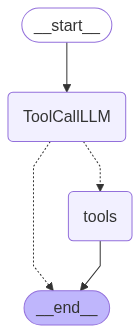

In [123]:
new_graph

In [124]:
new_response = new_graph.invoke({"messages": "Give recent AI news along with the date the news was published."})

In [125]:
new_response['messages'][-1].content

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.nature.com/collections/dbjajiahhh?utm_source=flipboard&utm_content=topic/technology", "title": "Advances in technologies and AI for improving and monitoring animal health, behaviour and welfare - Nature", "score": 0.808491587638855, "published_date": "Wed, 13 Aug 2025 20:14:57 GMT", "content": "Advances in technologies and AI for improving and monitoring animal health, behaviour and welfare 1.   nature Advances in technologies and AI for improving and monitoring animal health, behaviour and welfare Recent advances in technologies and artificial intelligence (AI) present vast potential to improve animal health and welfare by enabling novel methods for monitoring, detection, treatment and prevention of disease or stress. AI can assist in the analysis of complex datasets to develop machine learning algorithms for early detection and prediction of diseases, ultimately im

In [126]:
import json
json.loads(new_response['messages'][-1].content)['results']

[{'url': 'https://www.nature.com/collections/dbjajiahhh?utm_source=flipboard&utm_content=topic/technology',
  'title': 'Advances in technologies and AI for improving and monitoring animal health, behaviour and welfare - Nature',
  'score': 0.808491587638855,
  'published_date': 'Wed, 13 Aug 2025 20:14:57 GMT',
  'content': 'Advances in technologies and AI for improving and monitoring animal health, behaviour and welfare 1.   nature Advances in technologies and AI for improving and monitoring animal health, behaviour and welfare Recent advances in technologies and artificial intelligence (AI) present vast potential to improve animal health and welfare by enabling novel methods for monitoring, detection, treatment and prevention of disease or stress. AI can assist in the analysis of complex datasets to develop machine learning algorithms for early detection and prediction of diseases, ultimately improving animal health and welfare. We invite submissions of original research articles on t

In [127]:
for m in new_response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give recent AI news along with the date the news was published.
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_aUmu7HA7OVRNNGUxtuLcqhqB)
 Call ID: call_aUmu7HA7OVRNNGUxtuLcqhqB
  Args:
    query: recent AI news
    time_range: week
    topic: news
    search_depth: advanced
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.nature.com/collections/dbjajiahhh?utm_source=flipboard&utm_content=topic/technology", "title": "Advances in technologies and AI for improving and monitoring animal health, behaviour and welfare - Nature", "score": 0.808491587638855, "published_date": "Wed, 13 Aug 2025 20:14:57 GMT", "content": "Advances in technologies and AI for improving and monitor

In [128]:
multiply_response = new_graph.invoke({"messages": "What is 2 multipled by 10?"})

In [129]:
for m1 in multiply_response['messages']:
    m1.pretty_print()

================================ Human Message =================================

What is 2 multipled by 10?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_nF949goiz52PEcphXNIHTzFG)
 Call ID: call_nF949goiz52PEcphXNIHTzFG
  Args:
    a: 2
    b: 10
================================= Tool Message =================================
Name: multiply

20


#### 1.2.1 What's missing in above scenario?

If the bot is asked a complex query like `Give recent AI news along with the date the news was published. Then multiply 2 by 10.`, it will fail to do both the jobs. It will mostly complete the job given first in seqeuence i.e., the AI news part. Since the current graph flow directly ends after performing one task. Ideally, there should be some kind of recursive flow which allows for recursive calls to the `ToolsNode` until all the tasks in the given user query are served/completed.

Enter ReAct Agent

### 1.3 ReAct Architecture

In [130]:
### New StateGraph
new_builder = StateGraph(State)

## Add Nodes
new_builder.add_node("ToolCallLLM", tools_calling_llm)
new_builder.add_node("tools", ToolNode(tools))

## Add Edges
new_builder.add_edge(START, "ToolCallLLM")
# If the lastest message from the assistant is a tool call, tools_condition routes to "Tools"
# If the lastest message from the assistant is not a tool call, tools_condition routes to "END"
new_builder.add_conditional_edges("ToolCallLLM", tools_condition)
new_builder.add_edge("tools", "ToolCallLLM")

# Compile graph
react_graph = new_builder.compile()

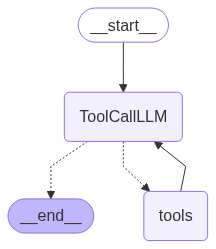

In [131]:
react_graph

In [132]:
react_response = react_graph.invoke({"messages": "Give recent AI news along with the date the news was published. Then multiply 2 by 50."})

In [133]:
for m in react_response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give recent AI news along with the date the news was published. Then multiply 2 by 50.
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_lJIv8hl2tjKLDz8t3BjmexFX)
 Call ID: call_lJIv8hl2tjKLDz8t3BjmexFX
  Args:
    query: recent AI news
    topic: news
    time_range: week
  multiply (call_Tac65A3qSR6rgd99mLONNI80)
 Call ID: call_Tac65A3qSR6rgd99mLONNI80
  Args:
    a: 2
    b: 50
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.telecoms.com/digital-ecosystem/ai?page=29", "title": "AI recent news | page 29 of 29 | Telecoms - Telecoms.com", "score": 0.72768575, "published_date": "Wed, 13 Aug 2025 11:27:25 GMT", "content": "AI recent news | page 29 of 29 | Telecoms Image 1 

### 1.4 Memory In Langchain.
Until the previous architecture, follow-up questions or queries may not be answered correctly because the LLM might not be able to remember the information from previous conversations. To enable this feature

_add to imports the following command_<break>
`from langchain.checkpoint.memory import MemorySaver`
`memory = MemorySaver()`

In [134]:
### New StateGraph
mem_enabled_react_builder = StateGraph(State)

## Add Nodes
mem_enabled_react_builder.add_node("ToolCallLLM", tools_calling_llm)
mem_enabled_react_builder.add_node("tools", ToolNode(tools))

## Add Edges
mem_enabled_react_builder.add_edge(START, "ToolCallLLM")
# If the lastest message from the assistant is a tool call, tools_condition routes to "Tools"
# If the lastest message from the assistant is not a tool call, tools_condition routes to "END"
mem_enabled_react_builder.add_conditional_edges("ToolCallLLM", tools_condition)
mem_enabled_react_builder.add_edge("tools", "ToolCallLLM")

# Compile graph
mem_enabled_react_graph = mem_enabled_react_builder.compile(checkpointer=memory)

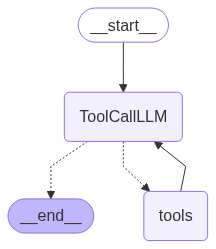

In [135]:
mem_enabled_react_graph

In [136]:
config = {"configurable": {"thread_id":"1"}}

In [137]:
mem_enabled_react_response = mem_enabled_react_graph.invoke({"messages": "Give recent AI news along with the date the news was published. Then multiply 2 by 50."}, config=config)

In [138]:
for m in mem_enabled_react_response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give recent AI news along with the date the news was published. Then multiply 2 by 50.
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_DoZ0HGHgeubornTgKIksILfX)
 Call ID: call_DoZ0HGHgeubornTgKIksILfX
  Args:
    query: recent AI news
    search_depth: basic
    topic: news
    include_favicon: False
  multiply (call_lQlxaGa5hYZWdKHgafQDFl5v)
 Call ID: call_lQlxaGa5hYZWdKHgafQDFl5v
  Args:
    a: 2
    b: 50
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.telecoms.com/digital-ecosystem/ai?page=29", "title": "AI recent news | page 29 of 29 | Telecoms - Telecoms.com", "score": 0.72768575, "published_date": "Wed, 13 Aug 2025 11:27:25 GMT", "content": "AI recent news | pag

In [139]:
mem_enabled_react_response1 = mem_enabled_react_graph.invoke({"messages": "What tasks did I give you previously?"}, config=config)
for m in mem_enabled_react_response1['messages']:
    m.pretty_print()

================================ Human Message =================================

Give recent AI news along with the date the news was published. Then multiply 2 by 50.
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_DoZ0HGHgeubornTgKIksILfX)
 Call ID: call_DoZ0HGHgeubornTgKIksILfX
  Args:
    query: recent AI news
    search_depth: basic
    topic: news
    include_favicon: False
  multiply (call_lQlxaGa5hYZWdKHgafQDFl5v)
 Call ID: call_lQlxaGa5hYZWdKHgafQDFl5v
  Args:
    a: 2
    b: 50
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.telecoms.com/digital-ecosystem/ai?page=29", "title": "AI recent news | page 29 of 29 | Telecoms - Telecoms.com", "score": 0.72768575, "published_date": "Wed, 13 Aug 2025 11:27:25 GMT", "content": "AI recent news | pag

In [140]:
## check how exactly the context is stored in the memory.
memory.blobs

defaultdict(None,
            {('1',
              '',
              '__start__',
              '00000000000000000000000000000001.0.7126665556347728'): ('msgpack',
              b'\x81\xa8messages\xd9VGive recent AI news along with the date the news was published. Then multiply 2 by 50.'),
             ('1',
              '',
              '__start__',
              '00000000000000000000000000000002.0.9641733704944351'): ('empty',
              b''),
             ('1',
              '',
              'messages',
              '00000000000000000000000000000002.0.9641733704944351'): ('msgpack',
              b'\x91\xc8\x01\n\x05\x94\xbdlangchain_core.messages.human\xacHumanMessage\x87\xa7content\xd9VGive recent AI news along with the date the news was published. Then multiply 2 by 50.\xb1additional_kwargs\x80\xb1response_metadata\x80\xa4type\xa5human\xa4name\xc0\xa2id\xd9$db08c7bc-4411-442c-8bd2-0be511743143\xa7example\xc2\xb3model_validate_json'),
             ('1',
              '',
  

### 1.5 Streaming in Langchain

In [141]:
streaming_memory = MemorySaver()

In [142]:
def superbot(state:State):
    return {"messages": [llm_with_tools.invoke(state['messages'])]}

In [143]:
streaming_graph = StateGraph(State)

# node
streaming_graph.add_node("SuperBot", superbot)

# edges
streaming_graph.add_edge(START, "SuperBot")
streaming_graph.add_edge("SuperBot", END)

compiled_streaming_graph = streaming_graph.compile(checkpointer=streaming_memory)

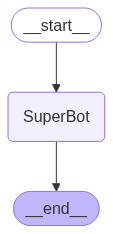

In [144]:
compiled_streaming_graph

In [145]:
# define config
streaming_config = {"configurable": {"thread_id": "1"}}

In [146]:
compiled_streaming_graph.invoke({"messages": "Hi, My name is AJ and I am a GenAI Engineer."}, config=streaming_config)

{'messages': [HumanMessage(content='Hi, My name is AJ and I am a GenAI Engineer.', additional_kwargs={}, response_metadata={}, id='70edeb06-bd5a-4bbd-bb3d-acb534870c32'),
  AIMessage(content="Hello AJ! It's great to meet a fellow enthusiast in the field of Generative AI. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 1319, 'total_tokens': 1345, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1280}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_df0f7b956c', 'id': 'chatcmpl-C64Gk58UUOZzitS7itLuzhPFmyw8S', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--45090fd2-cced-40be-9766-4754c7659766-0', usage_metadata={'input_tokens': 1319, 'output_tokens': 26, 'total_tokens': 1345, 'input_token_details': 

##### **Streaming Methods**
Methods: .stream() and astream()

- These methods are sync and async methods for streaming back results.

Additional parameters in streaming modes for graph state

- **values** : This streams the full state of the graph after each node is called.
- **updates** : This streams updates to the state of the graph after each node is called.

In [147]:
# define config
streaming_config1 = {"configurable": {"thread_id": "2"}}

for chunk in compiled_streaming_graph.stream({"messages": "Hi, My name is AJ and I am a GenAI Engineer."}, config=streaming_config1, stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Hi AJ! It's great to meet you. As a GenAI Engineer, you must be working on some exciting projects with generative AI. If there's anything specific you'd like to discuss or explore, feel free to let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 1319, 'total_tokens': 1366, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1280}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_df0f7b956c', 'id': 'chatcmpl-C64GlTdYrLP0WsRj7UuW2TALqc9eU', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--c1c662b0-df77-4bf1-afa3-a0fb32d37612-0', usage_metadata={'input_tokens': 1319, 'output_tokens': 47, 'total_tokens': 1366, 'input_token_details': {'audio': 0, 'cache_read': 1280}, 'output_token

In [148]:
for chunk in compiled_streaming_graph.stream({"messages": "Hi, My name is AJ and I am a GenAI Engineer."}, config=streaming_config1, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi, My name is AJ and I am a GenAI Engineer.', additional_kwargs={}, response_metadata={}, id='6449dcd9-7688-4f21-80e6-98afe6582558'), AIMessage(content="Hi AJ! It's great to meet you. As a GenAI Engineer, you must be working on some exciting projects with generative AI. If there's anything specific you'd like to discuss or explore, feel free to let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 1319, 'total_tokens': 1366, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1280}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_df0f7b956c', 'id': 'chatcmpl-C64GlTdYrLP0WsRj7UuW2TALqc9eU', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--c1c662b0-df77-4bf1-afa3-a0fb32d37612-0', usage_m

In [149]:
# define config
streaming_config2 = {"configurable": {"thread_id": "4"}}

for chunk in compiled_streaming_graph.stream({"messages": "Hi, My name is AJ and I am a GenAI Engineer."}, config=streaming_config2, stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Hello AJ! It's great to meet you. As a GenAI Engineer, you must be working on some exciting projects involving generative AI technologies. If you have any questions or need assistance with anything, feel free to ask!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 1319, 'total_tokens': 1365, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1280}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_df0f7b956c', 'id': 'chatcmpl-C64Gn4Y3Ux5OUpFugMui0j4GvTz3Q', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--25ef2b9f-6836-4e35-a3bd-e971b67c9340-0', usage_metadata={'input_tokens': 1319, 'output_tokens': 46, 'total_tokens': 1365, 'input_token_details': {'audio': 0, 'cache_read': 1280}, 'ou

In [150]:

for chunk in compiled_streaming_graph.stream({"messages": "I also like Indian Classical Music."}, config=streaming_config2, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi, My name is AJ and I am a GenAI Engineer.', additional_kwargs={}, response_metadata={}, id='f12057ea-fff6-4348-b9d3-52c1fc92c655'), AIMessage(content="Hello AJ! It's great to meet you. As a GenAI Engineer, you must be working on some exciting projects involving generative AI technologies. If you have any questions or need assistance with anything, feel free to ask!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 1319, 'total_tokens': 1365, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1280}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_df0f7b956c', 'id': 'chatcmpl-C64Gn4Y3Ux5OUpFugMui0j4GvTz3Q', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--25ef2b9f-6836-4e35-a3bd-e971b67c9340-0

In [151]:
# define config
streaming_config3 = {"configurable": {"thread_id": "5"}}

async for chunk in compiled_streaming_graph.astream_events({"messages": "Hi, My name is AJ and I am a GenAI Engineer."}, config=streaming_config3, version="v1"):
    print(chunk)

{'event': 'on_chain_start', 'run_id': '4c8b9eaf-3733-4b3f-9a5b-08d3994c1a9c', 'name': 'LangGraph', 'tags': [], 'metadata': {'thread_id': '5'}, 'data': {'input': {'messages': 'Hi, My name is AJ and I am a GenAI Engineer.'}}, 'parent_ids': []}
{'event': 'on_chain_start', 'name': 'SuperBot', 'run_id': '5b3e2134-1394-4ac0-9b8f-3879fe0886a5', 'tags': ['graph:step:1'], 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:dafb0764-5979-4b13-2110-76f10f4218fd'}, 'data': {'input': {'messages': [HumanMessage(content='Hi, My name is AJ and I am a GenAI Engineer.', additional_kwargs={}, response_metadata={}, id='76ee3a58-1efc-429f-bac7-135531ae2433')]}}, 'parent_ids': []}
{'event': 'on_chat_model_start', 'name': 'ChatOpenAI', 'run_id': 'ca65b2f0-b162-4268-bb5e-4f57aabd94c4', 'tags': ['seq:step:1'], 'metadata': {'thread_id': '5', 'langgrap

================================================= END =================================================